In [1]:
import numpy as np
import cv2
import albumentations as A
import matplotlib.pyplot as plt

In [4]:
def calculate_iou(box1, box2):
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    inter_area = max(0, x2_inter - x1_inter) * max(0, y2_inter - y1_inter)

    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - inter_area

    iou = inter_area / union_area if union_area > 0 else 0
    return iou

In [5]:
def non_max_suppression(boxes, iou_threshold):
    if not boxes:
        return []

    boxes_np = np.array(boxes)

    x1 = boxes_np[:, 0]
    y1 = boxes_np[:, 1]
    x2 = boxes_np[:, 2]
    y2 = boxes_np[:, 3]
    scores = boxes_np[:, 4]

    areas = (x2 - x1) * (y2 - y1)
    order = scores.argsort()[::-1]

    keep_indices = []
    while order.size > 0:
        i = order[0]
        keep_indices.append(i)

        remaining_indices = order[1:]
        if remaining_indices.size == 0:
            break

        xx1 = np.maximum(x1[i], x1[remaining_indices])
        yy1 = np.maximum(y1[i], y1[remaining_indices])
        xx2 = np.minimum(x2[i], x2[remaining_indices])
        yy2 = np.minimum(y2[i], y2[remaining_indices])

        w = np.maximum(0.0, xx2 - xx1)
        h = np.maximum(0.0, yy2 - yy1)
        inter = w * h

        iou = inter / (areas[i] + areas[remaining_indices] - inter)

        inds_to_keep = np.where(iou <= iou_threshold)[0]
        order = remaining_indices[inds_to_keep]

    return boxes_np[keep_indices].tolist()

print("--- Тестирование NMS ---")

# Пример входных данных: [x_min, y_min, x_max, y_max, confidence]
input_boxes = [
    [50, 50, 150, 150, 0.95],
    [60, 60, 160, 160, 0.90],
    [200, 200, 300, 300, 0.85],
    [210, 210, 310, 310, 0.88],
    [400, 100, 500, 200, 0.70],
    [50, 50, 155, 155, 0.60], # Еще один сильно пересекающийся с первым
]

iou_thresh = 0.5

print("Исходные боксы:")
for box in input_boxes:
    print(box)

final_boxes = non_max_suppression(input_boxes, iou_thresh)

print(f"\nБоксы после NMS (порог IoU = {iou_thresh}):")
for box in final_boxes:
    print(box)

print("-" * 30)


--- Тестирование NMS ---
Исходные боксы:
[50, 50, 150, 150, 0.95]
[60, 60, 160, 160, 0.9]
[200, 200, 300, 300, 0.85]
[210, 210, 310, 310, 0.88]
[400, 100, 500, 200, 0.7]
[50, 50, 155, 155, 0.6]

Боксы после NMS (порог IoU = 0.5):
[50.0, 50.0, 150.0, 150.0, 0.95]
[210.0, 210.0, 310.0, 310.0, 0.88]
[400.0, 100.0, 500.0, 200.0, 0.7]
------------------------------



--- Аугментация Изображений (Примеры) ---
Примечание: Для запуска нужна картинка 'test_image.jpg' и библиотеки cv2, albumentations, matplotlib.
Тестовое изображение 'test_image.jpg' загружено.


c:\Users\0\miniconda3\Lib\site-packages\albumentations\core\validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
c:\Users\0\miniconda3\Lib\site-packages\albumentations\core\composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


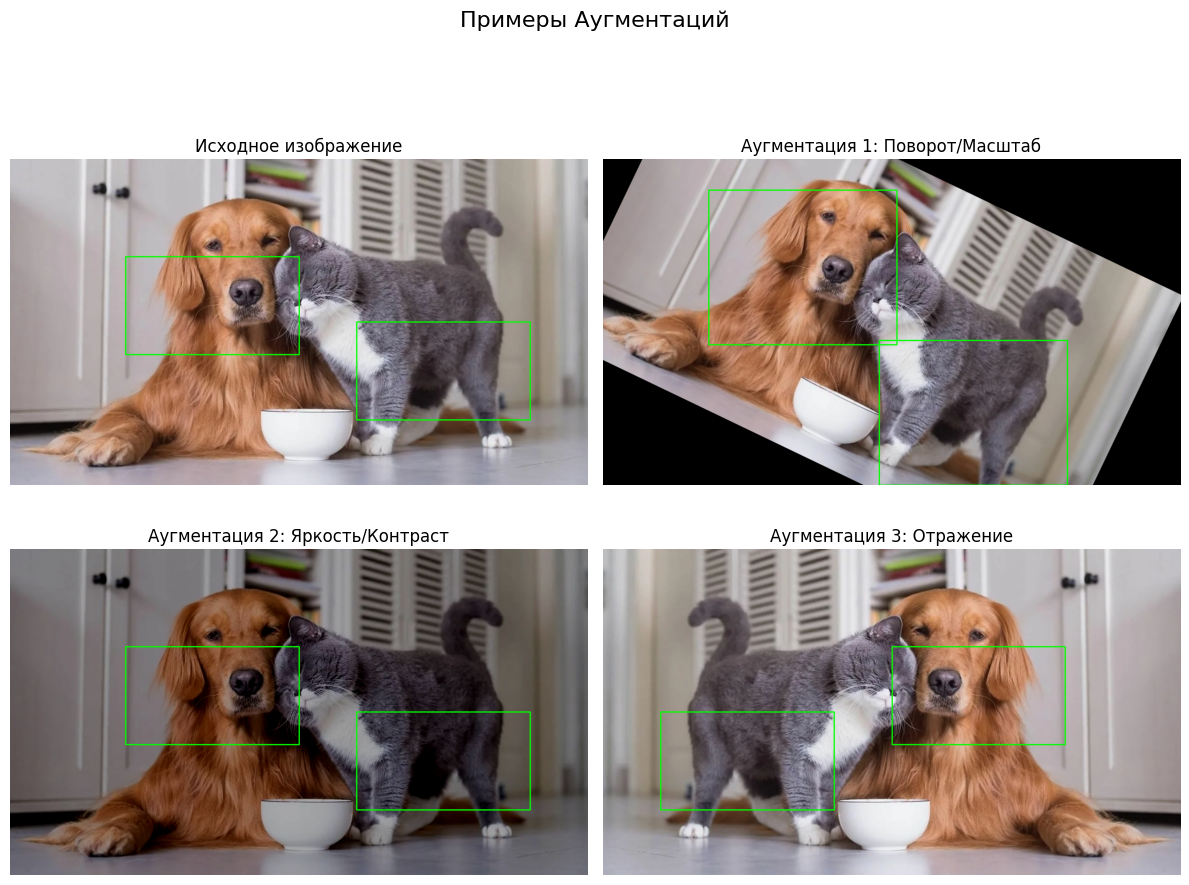


Завершение работы скрипта.


In [6]:
# ========== Часть 2: Дообучение и Аугментация ==========

# --- Дообучение Модели (Пример команды) ---
# Для дообучения потребуется установленная библиотека ultralytics
# и подготовленный датасет в формате YOLO (с yaml файлом конфигурации).
# Пример команды для запуска обучения из терминала:
# yolo detect train data=путь/к/вашему/data.yaml model=yolov8n.pt epochs=50 imgsz=640
#
# Или через Python API:
# from ultralytics import YOLO
# model = YOLO('yolov8n.pt') # Загрузка предобученной модели
# results = model.train(data='путь/к/вашему/data.yaml', epochs=50, imgsz=640)
# print("Обучение завершено.")

print("\n--- Аугментация Изображений (Примеры) ---")
print("Примечание: Для запуска нужна картинка 'test_image.jpg' и библиотеки cv2, albumentations, matplotlib.")

# --- Подготовка к аугментации ---
def draw_bboxes(img, boxes, color=(0, 255, 0), thickness=2):
    img_copy = img.copy()
    for box in boxes:
        # Формат бокса albumentations: [x_min_norm, y_min_norm, x_max_norm, y_max_norm, label]
        # Преобразуем нормализованные координаты в абсолютные
        h, w, _ = img.shape
        x_min = int(box[0] * w)
        y_min = int(box[1] * h)
        x_max = int(box[2] * w)
        y_max = int(box[3] * h)
        label = box[4]
        cv2.rectangle(img_copy, (x_min, y_min), (x_max, y_max), color, thickness)
        # Можно добавить текст метки, если нужно
        # cv2.putText(img_copy, str(label), (x_min, y_min - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    return img_copy

# Создадим "пустышку" изображения, если реального нет под рукой
# В реальном задании замените это на загрузку вашего изображения
try:
    image = cv2.imread('test_image.jpg')
    if image is None:
        raise FileNotFoundError
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print("Тестовое изображение 'test_image.jpg' загружено.")
    img_h, img_w, _ = image.shape
    # Пример боксов (в нормализованном формате [0,1] для albumentations) + метка класса
    # Используем числа (индексы классов) вместо строк
    bboxes = [
        [0.2, 0.3, 0.5, 0.6, 0], # 0 - для 'cat'
        [0.6, 0.5, 0.9, 0.8, 1], # 1 - для 'dog'
    ]
    # Теперь извлекаем эти числовые метки
    class_labels = [b[4] for b in bboxes]
except FileNotFoundError:
    print("Файл 'test_image.jpg' не найден. Создаю простое изображение для демонстрации.")
    image = np.ones((300, 400, 3), dtype=np.uint8) * 200 # Серое изображение
    img_h, img_w, _ = image.shape
    # ИСПРАВЛЕНО: Используем числовые индексы и здесь
    bboxes = [
        [0.1, 0.1, 0.4, 0.4, 0], # Индекс 0 для 'obj1'
        [0.6, 0.6, 0.9, 0.9, 1], # Индекс 1 для 'obj2'
    ]
    # ИСПРАВЛЕНО: Определяем class_labels и здесь
    class_labels = [b[4] for b in bboxes]

# Настройка параметров для боксов в albumentations
bbox_params = A.BboxParams(format='albumentations', # или 'pascal_voc', 'coco', 'yolo'
                             label_fields=['class_labels'])


# --- Аугментация 1: Поворот и Масштабирование ---
transform1 = A.Compose([
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=30, p=1.0, border_mode=cv2.BORDER_CONSTANT)
], bbox_params=bbox_params)

# --- Аугментация 2: Изменение Яркости и Контраста ---
transform2 = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=1.0)
], bbox_params=bbox_params)

# --- Аугментация 3: Горизонтальное отражение ---
transform3 = A.Compose([
    A.HorizontalFlip(p=1.0)
], bbox_params=bbox_params)


# Применение и визуализация
try:
    # ИСПРАВЛЕНО: Используем переменную class_labels, а не вычисляем заново
    transformed1 = transform1(image=image, bboxes=bboxes, class_labels=class_labels)
    transformed2 = transform2(image=image, bboxes=bboxes, class_labels=class_labels)
    transformed3 = transform3(image=image, bboxes=bboxes, class_labels=class_labels)

    image_orig_boxed = draw_bboxes(image, bboxes)
    image_aug1_boxed = draw_bboxes(transformed1['image'], transformed1['bboxes'])
    image_aug2_boxed = draw_bboxes(transformed2['image'], transformed2['bboxes'])
    image_aug3_boxed = draw_bboxes(transformed3['image'], transformed3['bboxes'])

    # Отображение результатов
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    fig.suptitle("Примеры Аугментаций", fontsize=16)

    axs[0, 0].imshow(image_orig_boxed)
    axs[0, 0].set_title("Исходное изображение")
    axs[0, 0].axis('off')

    axs[0, 1].imshow(image_aug1_boxed)
    axs[0, 1].set_title("Аугментация 1: Поворот/Масштаб")
    axs[0, 1].axis('off')

    axs[1, 0].imshow(image_aug2_boxed)
    axs[1, 0].set_title("Аугментация 2: Яркость/Контраст")
    axs[1, 0].axis('off')

    axs[1, 1].imshow(image_aug3_boxed)
    axs[1, 1].set_title("Аугментация 3: Отражение")
    axs[1, 1].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Учитываем suptitle
    plt.show()

except Exception as e:
    print(f"\nНе удалось выполнить аугментацию или отображение: {e}")
    print("Убедитесь, что установлены 'opencv-python', 'albumentations', 'matplotlib' и есть тестовое изображение.")

print("\nЗавершение работы скрипта.")